### Heartbeat Sound Anomalies Detection
----

#### Problem Statement:
-----

* According to the World Health Organisation, cardiovascular diseases (CVDs) are the number one cause of death globally: more people die annually from CVDs than from any other cause. An estimated 17.1 million people died from CVDs in 2004, representing 29% of all global deaths. Of these deaths, an estimated 7.2 million were due to coronary heart disease. Any method which can help to detect signs of heart disease could therefore have a significant impact on world health. This challenge is to produce methods to do exactly that. Specifically, we are interested in creating the first level of screening of cardiac pathologies both in a Hospital environment by a doctor (using a digital stethoscope) and at home by the patient (using a mobile device).

* The problem is of particular interest to machine learning researchers as it involves classification of audio sample data, where distinguishing between classes of interest is non-trivial. Data is gathered in real-world situations and frequently contains background noise of every conceivable type. The differences between heart sounds corresponding to different heart symptoms can also be extremely subtle and challenging to separate. Success in classifying this form of data requires extremely robust classifiers. Despite its medical significance, to date this is a relatively unexplored application for machine learning.

#### Dataset Overview:
----
* Data has been gathered from two sources: 
1. The general public via the iStethoscope Pro iPhone app, provided in Dataset A. 
2. A clinic trial in hospitals using the digital stethoscope DigiScope, provided in Dataset B.

* Source 1: http://www.peterjbentley.com/heartchallenge/#downloads
* Source 2: https://www.kaggle.com/kinguistics/heartbeat-sounds

#### Citation:
-----
* @misc{pascal-chsc-2011,
       author = "Bentley, P. and Nordehn, G. and Coimbra, M. and Mannor, S.",
       title = "The {PASCAL} {C}lassifying {H}eart {S}ounds {C}hallenge 2011 {(CHSC2011)} {R}esults",
       howpublished = "http://www.peterjbentley.com/heartchallenge/index.html"}


### Loading Packages and Dependencies
----

In [12]:
import pandas as pd
import numpy as np
import re, sys
import librosa
from tqdm import tqdm_notebook,tqdm
import string
import warnings
import matplotlib.pyplot as plt
from IPython.display import Audio,display
from librosa.feature import mfcc
from librosa.display import specshow,waveplot
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

### Dataset Exploration
----

In [13]:
#The dataset includes information about each file and class it belong
istethoscope_dataset = pd.read_csv(r'D:\heartbeat-sounds\set_a.csv') 
digiscope_dataset = pd.read_csv(r'D:\heartbeat-sounds\set_b.csv')

In [14]:
istethoscope_dataset.sample(5)

dataset                             fname     label  sublabel
60        a    set_a/murmur__201101051108.wav    murmur       NaN
99        a    set_a/normal__201102270940.wav    normal       NaN
66        a    set_a/murmur__201104021355.wav    murmur       NaN
151       a          set_a/__201106061104.wav       NaN       NaN
41        a  set_a/extrahls__201101091153.wav  extrahls       NaN

In [15]:
digiscope_dataset.sample(5)

dataset                                              fname       label  \
256       b     set_b/Btraining_normal_217_1308246111629_C.wav      normal   
331       b      set_b/Bunlabelledtest_115_1306259437619_D.wav         NaN   
13        b  set_b/Btraining_extrastole_179_1307990076841_C...  extrastole   
409       b      set_b/Bunlabelledtest_171_1307971016233_C.wav         NaN   
447       b      set_b/Bunlabelledtest_209_1308162216750_C.wav         NaN   

    sublabel  
256      NaN  
331      NaN  
13       NaN  
409      NaN  
447      NaN

iStethoscope Rows: 176
iStethoscope Columns: 4

DigiScope Rows: 656
DigiScope Columns: 4



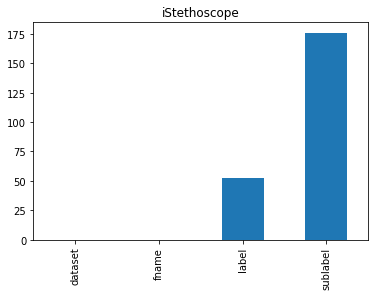

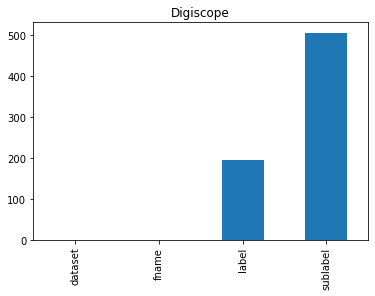

In [16]:
#Checking training dataset

#Checking iStethoscope
print('iStethoscope Rows:',istethoscope_dataset.shape[0])
print('iStethoscope Columns:',istethoscope_dataset.shape[1])

print()

#Checking Digiscope
print('DigiScope Rows:',digiscope_dataset.shape[0])
print('DigiScope Columns:',digiscope_dataset.shape[1])

print()

#Checking missing value iStethoscope
istethoscope_dataset.isnull().sum().plot(kind='bar')
plt.title('iStethoscope')
plt.show()

#Checking missing value Digiscope
digiscope_dataset.isnull().sum().plot(kind='bar')
plt.title('Digiscope')
plt.show()

In [17]:
# Deleting the column sublabel and dataset
istethoscope_dataset.drop(axis=1, columns=['dataset','sublabel'], inplace=True)
digiscope_dataset.drop(axis=1, columns=['dataset','sublabel'], inplace=True)

In [18]:
# For istethoscope dataset we will devide the data into training and testing such that all the label where the valus are NAN will be our testing
# and all the label where the values are present will be our training 
istethoscope_train_data = istethoscope_dataset[istethoscope_dataset['label'].notnull()]
istethoscope_test_data = istethoscope_dataset[istethoscope_dataset['label'].isnull()]

# For digiscope dataset we will devide the data into training and testing such that all the label where the valus are NAN will be our testing
# and all the label where the values are present will be our training 
digiscope_train_data = digiscope_dataset[digiscope_dataset['label'].notnull()]
digiscope_test_data = digiscope_dataset[digiscope_dataset['label'].isnull()]

# digiscope_train_data['fname'] = digiscope_train_data['fname'].str.replace('Btraining_','')

In [73]:
Classes = istethoscope_train_data['label'].unique() #getting class and displaying them
for class_label in Classes:
    print(class_label)

artifact
extrahls
murmur
normal


In [19]:
#File location of all .wav file
fileloc = 'D:/heartbeat-sounds/'
plt.figure(figsize=(16, 3))
#Displaying for istethoscope
for filename in list(np.random.choice(istethoscope_train_data['fname'].values, size=4, replace=False)):
    print(' '.join(istethoscope_train_data[istethoscope_train_data['fname']==filename]['label'].values))
    display(Audio(f'{fileloc}{filename}',rate=22050))

artifact


normal


extrahls


extrahls


<Figure size 1152x216 with 0 Axes>

### Visualizing using Waveplot and MFCC
----

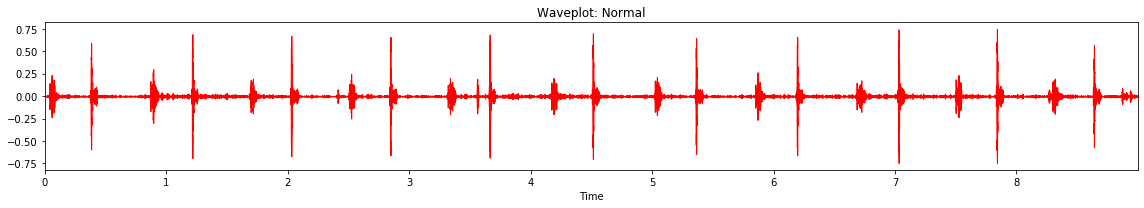

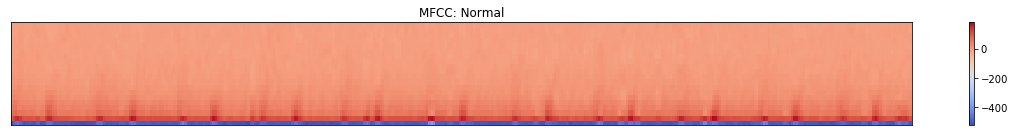

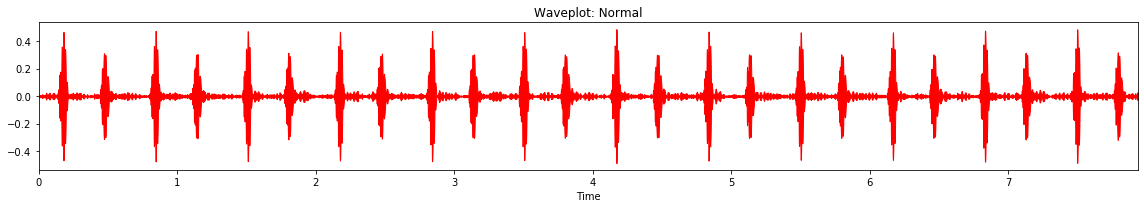

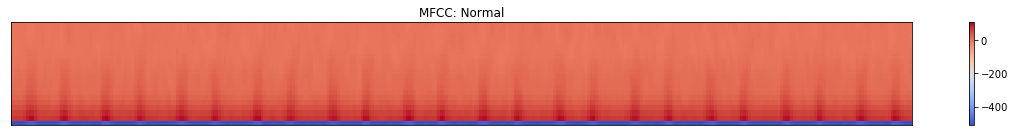

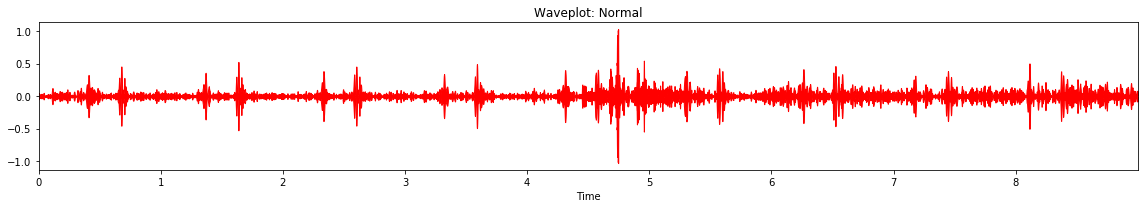

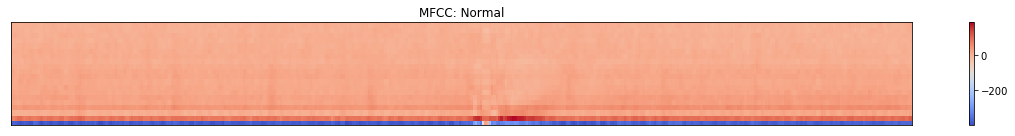

In [20]:
#Function to display the audio file in wave
def create_waveplot(filename,title):
    plt.figure(figsize=(16,3))
    y, sr = librosa.load(f'{fileloc}{filename}')
    waveplot(y,sr,color='r')
    plt.title(f'Waveplot: {title.capitalize()}')
    plt.tight_layout()
    plt.show()
    
#Function to display the audio file in mfcc 
def create_mfcc(filename,title):
    plt.figure(figsize=(16,2))
    y,sr = librosa.load(f'{fileloc}{filename}')
    mfcc = librosa.feature.mfcc(y,sr)
    librosa.display.specshow(mfcc)
    plt.colorbar()
    plt.title(f'MFCC: {title.capitalize()}')
    plt.tight_layout()
    plt.show()
    
#Displaying the audio files    
for filename in list(np.random.choice(istethoscope_train_data['fname'].values, size=3, replace=False)):
    title = ' '.join(istethoscope_train_data[istethoscope_train_data['fname']==filename]['label'].values)
    create_waveplot(filename,title)
    create_mfcc(filename,title)

### Building Model only for iStethoscope Data
----

### Feature Extraction Using MFCC
----

In [21]:
#Extracting the feature using MFCC for convolution
def extract_mfcc(filename):
    max_pad_len = 388
    audio, sample_rate = librosa.load(f'{fileloc}{filename}')
    mfcc = librosa.feature.mfcc(audio, sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)),mode='constant')
    return mfcc

#Extracting the feature using MFCC for LSTM    
def extract_mfcc_for_lstm(filename):
    audio, sample_rate = librosa.load(f'{fileloc}{filename}')
    mfcc = np.array(np.mean(librosa.feature.mfcc(audio, sample_rate,n_mfcc=40).T,axis=0)).reshape([-1,1])
    return mfcc

istethoscope_train_data['features_conv'] = istethoscope_train_data['fname'].apply(lambda x: extract_mfcc(x))
istethoscope_train_data['features_lstm'] = istethoscope_train_data['fname'].apply(lambda x: extract_mfcc_for_lstm(x))
istethoscope_train_data.drop(columns=['fname'],inplace=True)

In [23]:
X_conv = np.array(istethoscope_train_data['features_conv'].tolist())
y_conv = np.array(istethoscope_train_data['label'].tolist())

X_lstm = np.array(istethoscope_train_data['features_lstm'].tolist())
y_lstm = np.array(istethoscope_train_data['label'].tolist())

labelencode = LabelEncoder()
y_conv = to_categorical(labelencode.fit_transform(y_conv))
y_lstm = to_categorical(labelencode.fit_transform(y_lstm))

xtrain_conv, xtest_conv, ytrain_conv, ytest_conv = train_test_split(X_conv,y_conv,test_size=0.2,random_state=45)
xtrain_lstm, xtest_lstm, ytrain_lstm, ytest_lstm = train_test_split(X_lstm,y_lstm,test_size=0.2,random_state=45)

### LSTM Architecture
----

In [31]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=64,recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
#model_lstm.add(Bidirectional(LSTM(units=64,recurrent_dropout=0.20, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(units=128,recurrent_dropout=0.20, return_sequences=False)))
model_lstm.add(Dense(4, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 40, 64)            16896     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 215,556
Trainable params: 215,556
Non-trainable params: 0
_________________________________________________________________


In [32]:
epoch = 50
with tqdm_notebook(total=epoch, unit='epoch') as t:
    def cbk(epoch, logs):
        t.set_postfix(logs, refresh=False)
        t.update()
    cbkwrapped = LambdaCallback(on_epoch_end=cbk)
    history = model_lstm.fit(xtrain_lstm, ytrain_lstm, epochs=epoch, validation_data=(xtest_lstm,ytest_lstm), verbose=0, callbacks=[cbkwrapped], batch_size=128)

In [37]:
print('Validation Accuracy:',round(model_lstm.evaluate(xtest_lstm,ytest_lstm)[1],2))

25/25 [==============================] - 0s 758us/sample - loss: 0.4222 - accuracy: 0.8400
Validation Accuracy: 0.84


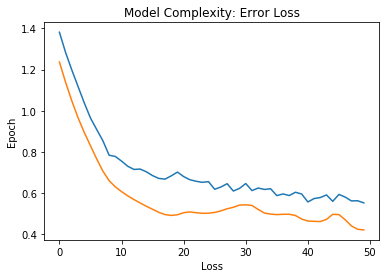

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Complexity: Error Loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.show()

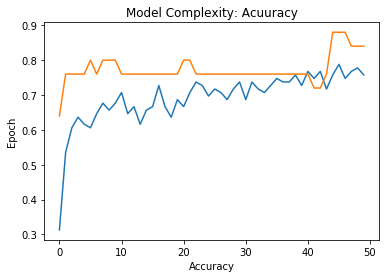

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Complexity: Acuuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.show()

In [58]:
model_lstm.save('Hearbeat_model_lstm.h5')

### CNN Model
----

In [38]:
num_rows = 40
num_columns = 388
num_channels = 1

xtrain_conv = xtrain_conv.reshape(xtrain_conv.shape[0], num_rows, num_columns, num_channels)
xtest_conv = xtest_conv.reshape(xtest_conv.shape[0], num_rows, num_columns, num_channels)

In [39]:
xtrain_conv.shape
xtest_conv.shape

(25, 40, 388, 1)

In [62]:
model_conv = Sequential()

model_conv.add(Conv2D(filters=32, kernel_size=2, activation='relu',input_shape=xtrain_conv.shape[1:]))
model_conv.add(MaxPooling2D())
model_conv.add(Dropout(0.5))

model_conv.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_conv.add(MaxPooling2D())
model_conv.add(Dropout(0.5))

model_conv.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_conv.add(MaxPooling2D())
model_conv.add(Dropout(0.5))

model_conv.add(GlobalAveragePooling2D())
model_conv.add(Dense(4,activation='softmax'))

model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 39, 387, 32)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 193, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 193, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 192, 64)       8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 96, 64)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 96, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 95, 128)       

In [63]:
epoch = 150
with tqdm_notebook(total=epoch, unit='epoch') as t:
    def cbk(epoch, logs):
        t.set_postfix(logs, refresh=False)
        t.update()
    cbkwrapped = LambdaCallback(on_epoch_end=cbk)
    hist = model_conv.fit(xtrain_conv, ytrain_conv, epochs=epoch, validation_data=(xtest_conv,ytest_conv), verbose=0, callbacks=[cbkwrapped], batch_size=128)

In [67]:
print('Validation Accuracy:',round(model_conv.evaluate(xtest_conv,ytest_conv)[1],2))

25/25 [==============================] - 0s 3ms/sample - loss: 0.7237 - accuracy: 0.7600
Validation Accuracy: 0.76


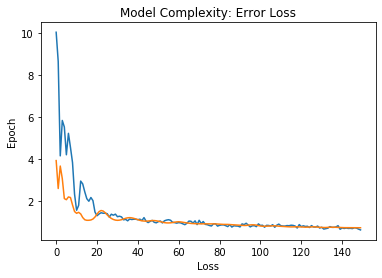

In [68]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Complexity: Error Loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.show()

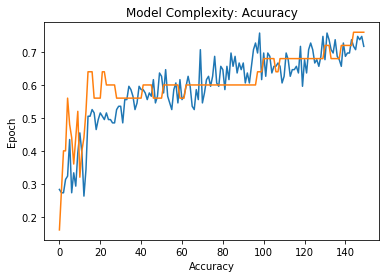

In [69]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Complexity: Acuuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.show()

In [70]:
model_conv.save('Heatbeat_conv.h5')

### Conclusion
-----

* LSTM model produce 84% of Accuracy in test set
* Convolution model produce 76%  of Accuracy in test set